<a href="https://colab.research.google.com/github/LNshuti/bloomberg/blob/main/DePrado_Advances_financialML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install openai --quiet
!pip install PyPDF2 --quiet
!pip install google-colab --quiet
!pip install gradio --quiet

# Trading Strategy Risk

## Advances in Financial Machine Learning.
LOPEZ DE PRADO
---

### Chapter 15-16

In [96]:
import numpy as np
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pandas as pd
import time

In [97]:
# cov,corr = x.cov(), x.corr()
# dist= ((1-corr)/2.)**.5 # distance mastrix
# link = sch.linkage(dist,'single') # linkage matrix

In [98]:
# Calculate the implied precision
def binHR(sl, pt, freq, tSR):
  '''
  Given a trading rule characterized by the parameters {sl, pt, freq}, what's the min precision p required to achieve a sharpe ratio tSR?
  1) Inputs
  sl: stop loss threshold
  pt: profit taking threshold
  freq: number of bets per year

  tSR: target annual sharpe ratio
  2) output
  p: the min precision rate p required to achieve tSR
  ```
  a=(freq+tSR**2)*(pt-sl)**2
  b=
  c=
  p=
  return p
  '''

In [99]:
def mixGaussians(mu1, mu2, sigma1,sigma2, prob1,nObs):
  # Random draws from a mixture of gaussians
  ret1=np.random.normal(mu1,sigma1,size=int(nObs*prob1))
  ret2=np.random.normal(mu2,sigma2,int(nObs)-ret1.shape[0])
  ret = np.append(ret1, ret2, axis=0)
  np.random.shuffle(ret)
  return ret

In [100]:
def probFailure(ret, freq, tSR):
  # Derive probability that strategy may fail
  rPos,rNeg=ret[ret>0].mean(),ret[ret<=0].mean()
  p=ret[ret>0].shape[0]/float(ret.shape[0])

  tresP = binHR(rNeg, rPos, freq, tSR)
  risk = ss.norm.cdf(tresP,p,p*(1-p)) # approximation to bootstrap
  return risk

In [101]:
def main():
  # 1. Parameters
  mu1, mu2, sigma1, sigma2, prob1, nObs=0.05,-0.1,0.05, 0.1,0.75,35000
  tSR,freq=2.,350
  # 2. Generate sample from mixture
  ret=mixGaussians(mu1,mu2,sigma1,sigma2,prob1,nObs)
  print(ret)
  # 3. Calculate probability of failure
  probF = probFailure(ret,freq,tSR)
  print(probF)
  #print('Probability strategy will fail:' probF)
  return

if __name__ == '__main__':
  main()


[-0.03815926 -0.00107288 -0.02237761 ... -0.20696229  0.05917802
  0.08211311]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [102]:
def getQuasiDiag(link):
  # sort clustered items by distance
  link = link.astype(int)
  sortIx = pd.Series([link[-1,0], link[-1,1]])
  numItems=link[-1,3]
  while sortIx.max()>=numItems:
    sortIx.index=range(0,sortIx.shape[0]*2,2)
    df0=sortIx[sortIx>=numItems]
    i=df0.index;j=df0.values-numItems
    sortIx[i]=link[j,0]
    df0=sortIx[sortIx>=numItems]
    i=df0.index;j=df0.values-numItems
    sortIx[i]=link[j,1]
    sortIx=sortIx.sort_index()
  return sortIx.tolist()

In [103]:
# Recursive Bisection
def getRecBipart(cov,sortIx):
  # Compute HRP alloc
  w=pd.Series(1,index=sortIx)


  return w

In [104]:
def plugIn(msg,w):
  # Compute plug-in (ML) entropy rate
  pmf = pmf1(msg,w)
  out = -sum([pmf[i]*np.log2(pmf[i]) for i in pmf]) / w
  return out, pmf

In [105]:
def pmf1(msg,w):
  # Compute the prob mass function for a one-dim discrete rv
  lib = {}
  if not isinstance(msg,str):msg=''.join(map(str,msg))
  for i in xrange(w,len(msg)):
    msg_=msg[i-w:i]
    if msg_ in lib:lib[msg_]+=1
    else:lib[msg_]=1
  pmf=float(len(msg)-w)
  pmf = {i:len(lib[i])/pmf for i in lib}
  return pmf

In [106]:
def getBeta(series,s1):
  h1=series[['High','Low']].values

In [107]:
def getGamma(series):
  h2 = pd.stats.moments.rollng_max(series['High'], window=2)
  l2 = pd.stats.moments.rollng_min(series['Low'], window=2)
  gamma = np.log(h2.values/l2.values)**2
  gamma = pd.Series(gamma, index=series.index)
  return gamma.dropna()

In [108]:
def getAlpha(beta, gamma):
  den = 3-2*2**.5
  alpha = (2**.5-1)*(beta**.5)*(gamma**.5)/den
  return alpha.dropna()

In [109]:
def corwinSchultz(series, sl=1):
  # Note: S<0 iif alpha < 0
  beta = getBeta(series, sl)
  gamma = getGamma(series)
  alpha = getAlpha(beta, gamma)
  spread = 2* (np.exp(alpha)-1)/(1+np.exp(alpha))
  startTime = pd.Series(series.index[0:spread.shape[0]], index=spread.index)
  spread=pd.concat([spread,startTime], axis=1)
  spread.columns=['Spread','StartTime']
  return spread

In [111]:
def getSigma(beta,gamma):
  k2=(8/np.pi)**0.5
  den=3-2*2**0.5
  sigma=(2**-0.5-1)*beta**0.5/(k2*den)
  sigma +=(gamma/(k2**2*den))**0.5

  sigma[sigma<0]=0
  return sigma

# Causal Machine Learning

In [112]:
!pip install pyfixest --quiet
!pip install pylatex --quiet
!pip install gradio --quiet

In [113]:
import numpy as np
import pandas as pd
import pylatex as pl  # for the latex table; note: not a dependency of pyfixest - needs manual installation
from great_tables import loc, style
from IPython.display import FileLink, display

import pyfixest as pf

%load_ext autoreload
%autoreload 2

data = pf.get_data()

fit1 = pf.feols("Y ~ X1 + X2 | f1", data=data)
fit2 = pf.feols("Y ~ X1 + X2 | f1 + f2", data=data)
fit3 = pf.feols("Y ~ X1 *X2 | f1 + f2", data=data)
fit4 = pf.feols("Y2 ~ X1 + X2 | f1", data=data)
fit5 = pf.feols("Y2 ~ X1 + X2 | f1 + f2", data=data)
fit6 = pf.feols("Y2 ~ X1 *X2 | f1 + f2", data=data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
pf.etable([fit1, fit2, fit3, fit4, fit5, fit6])

GT(_tbl_data=  level_0        level_1                       0                       1  \
0    coef             X1  -0.950*** <br> (0.067)  -0.924*** <br> (0.061)   
1    coef             X2  -0.174*** <br> (0.018)  -0.174*** <br> (0.015)   
2    coef          X1:X2                                                   
3      fe             f2                       -                       x   
4      fe             f1                       x                       x   
5   stats   Observations                     997                     997   
6   stats      S.E. type                  by: f1                  by: f1   
7   stats  R<sup>2</sup>                   0.489                   0.659   

                        2                       3                       4  \
0  -0.924*** <br> (0.061)  -1.267*** <br> (0.174)  -1.232*** <br> (0.192)   
1  -0.185*** <br> (0.025)   -0.131** <br> (0.042)   -0.118** <br> (0.042)   
2      0.011 <br> (0.018)                                                   
3                       x                       -                       x   
4                       x                       x                       x   
5                     997                     998                     998   
6                  by: f1                  by: f1                  by: f1   
7                   0.659                   0.120                   0.172   

                        5  
0  -1.231*** <br> (0.192)  
1     -0.074 <br> (0.104)  
2     -0.041 <br> (0.081)  
3                       x  
4                       x  
5                     998  
6                  by: f1  
7                   0.172  , _body=<great_tables._gt_data.Body object at 0x795995873bb0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x795995872b30>, _spanners=Spanners([SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None), SpannerInfo(spanner_id='Y2', spanner_level=1, spanner_label='Y2', spanner_units=None, spanner_pattern=None, vars=['3', '4', '5'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[''], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x795995872f20>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category=

In [115]:
pf.etable(pf.feols("Y+Y2~csw(X1,X2,X1:X2)", data=data))

GT(_tbl_data=  level_0        level_1                       0                       1  \
0    coef             X1  -1.000*** <br> (0.085)  -0.993*** <br> (0.082)   
1    coef             X2                          -0.176*** <br> (0.022)   
2    coef          X1:X2                                                   
3    coef      Intercept   0.919*** <br> (0.112)   0.889*** <br> (0.108)   
4   stats   Observations                     998                     998   
5   stats      S.E. type                     iid                     iid   
6   stats  R<sup>2</sup>                   0.123                   0.177   

                        2                       3                       4  \
0  -0.992*** <br> (0.082)  -1.322*** <br> (0.215)  -1.316*** <br> (0.214)   
1  -0.197*** <br> (0.036)                            -0.133* <br> (0.057)   
2      0.020 <br> (0.027)                                                   
3   0.888*** <br> (0.108)   1.064*** <br> (0.283)   1.042*** <br> (0.283)   
4                     998                     999                     999   
5                     iid                     iid                     iid   
6                   0.177                   0.037                   0.042   

                        5  
0  -1.316*** <br> (0.215)  
1     -0.132 <br> (0.095)  
2     -0.001 <br> (0.071)  
3   1.042*** <br> (0.283)  
4                     999  
5                     iid  
6                   0.042  , _body=<great_tables._gt_data.Body object at 0x7959a4cb7430>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7959a4cb6bc0>, _spanners=Spanners([SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None), SpannerInfo(spanner_id='Y2', spanner_level=1, spanner_label='Y2', spanner_units=None, spanner_pattern=None, vars=['3', '4', '5'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[''], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7959a4cb6b60>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 's

In [116]:
pf.etable([fit1, fit2, fit3, fit4, fit5, fit6], keep="X1")

GT(_tbl_data=  level_0        level_1                       0                       1  \
0    coef             X1  -0.950*** <br> (0.067)  -0.924*** <br> (0.061)   
1    coef          X1:X2                                                   
2      fe             f2                       -                       x   
3      fe             f1                       x                       x   
4   stats   Observations                     997                     997   
5   stats      S.E. type                  by: f1                  by: f1   
6   stats  R<sup>2</sup>                   0.489                   0.659   

                        2                       3                       4  \
0  -0.924*** <br> (0.061)  -1.267*** <br> (0.174)  -1.232*** <br> (0.192)   
1      0.011 <br> (0.018)                                                   
2                       x                       -                       x   
3                       x                       x                       x   
4                     997                     998                     998   
5                  by: f1                  by: f1                  by: f1   
6                   0.659                   0.120                   0.172   

                        5  
0  -1.231*** <br> (0.192)  
1     -0.041 <br> (0.081)  
2                       x  
3                       x  
4                     998  
5                  by: f1  
6                   0.172  , _body=<great_tables._gt_data.Body object at 0x795997e13100>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x79599722ec80>, _spanners=Spanners([SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None), SpannerInfo(spanner_id='Y2', spanner_level=1, spanner_label='Y2', spanner_units=None, spanner_pattern=None, vars=['3', '4', '5'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[''], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x795997e13940>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 's

In [117]:
pf.etable([fit1, fit2, fit3, fit4, fit5, fit6], keep=["X1", "X2"], exact_match=True)

GT(_tbl_data=  level_0        level_1                       0                       1  \
0    coef             X1  -0.950*** <br> (0.067)  -0.924*** <br> (0.061)   
1    coef             X2  -0.174*** <br> (0.018)  -0.174*** <br> (0.015)   
2      fe             f2                       -                       x   
3      fe             f1                       x                       x   
4   stats   Observations                     997                     997   
5   stats      S.E. type                  by: f1                  by: f1   
6   stats  R<sup>2</sup>                   0.489                   0.659   

                        2                       3                       4  \
0  -0.924*** <br> (0.061)  -1.267*** <br> (0.174)  -1.232*** <br> (0.192)   
1  -0.185*** <br> (0.025)   -0.131** <br> (0.042)   -0.118** <br> (0.042)   
2                       x                       -                       x   
3                       x                       x                       x   
4                     997                     998                     998   
5                  by: f1                  by: f1                  by: f1   
6                   0.659                   0.120                   0.172   

                        5  
0  -1.231*** <br> (0.192)  
1     -0.074 <br> (0.104)  
2                       x  
3                       x  
4                     998  
5                  by: f1  
6                   0.172  , _body=<great_tables._gt_data.Body object at 0x795997c97ac0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x795997f30610>, _spanners=Spanners([SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None), SpannerInfo(spanner_id='Y2', spanner_level=1, spanner_label='Y2', spanner_units=None, spanner_pattern=None, vars=['3', '4', '5'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[''], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x795997c94ac0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 's

In [118]:
import pyfixest as pf

data = pf.get_data()
pf.feols("Y ~ X1 | f1 + f2", data=data).summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1+f2
Inference:  CRV1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -0.919 |        0.065 |   -14.057 |      0.000 | -1.053 |  -0.786 |
---
RMSE: 1.441 R2: 0.609 R2 Within: 0.2 


In [119]:
# OLS Estimation: estimate multiple models at once
fit = pf.feols("Y + Y2 ~X1 | csw0(f1, f2)", data = data, vcov = {'CRV1':'group_id'})
# Print the results
fit.etable()

GT(_tbl_data=  level_0        level_1                       0                       1  \
0    coef             X1  -1.000*** <br> (0.117)  -1.322*** <br> (0.211)   
1    coef      Intercept   0.919*** <br> (0.121)   1.064*** <br> (0.232)   
2      fe             f2                       -                       -   
3      fe             f1                       -                       -   
4   stats   Observations                     998                     999   
5   stats      S.E. type            by: group_id            by: group_id   
6   stats  R<sup>2</sup>                   0.123                   0.037   

                        2                       3                       4  \
0  -0.949*** <br> (0.087)  -1.266*** <br> (0.212)  -0.919*** <br> (0.069)   
1                                                                           
2                       -                       -                       x   
3                       x                       x                       x   
4                     997                     998                     997   
5            by: group_id            by: group_id            by: group_id   
6                   0.437                   0.115                   0.609   

                        5  
0  -1.228*** <br> (0.194)  
1                          
2                       x  
3                       x  
4                     998  
5            by: group_id  
6                   0.168  , _body=<great_tables._gt_data.Body object at 0x7959a54aad70>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x79599731f190>, _spanners=Spanners([SpannerInfo(spanner_id='Y', spanner_level=1, spanner_label='Y', spanner_units=None, spanner_pattern=None, vars=['0', '2', '4'], built=None), SpannerInfo(spanner_id='Y2', spanner_level=1, spanner_label='Y2', spanner_units=None, spanner_pattern=None, vars=['1', '3', '5'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[''], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7959a54abdc0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 's

In [120]:
fit1 = fit.fetch_model(0)
fit1.vcov("hetero").summary()

Model:  Y~X1
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 0
Inference:  hetero
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.919 |        0.112 |     8.223 |      0.000 |  0.699 |   1.138 |
| X1            |     -1.000 |        0.082 |   -12.134 |      0.000 | -1.162 |  -0.838 |
---
RMSE: 2.158 R2: 0.123 


In [121]:
poisson_data = pf.get_data(model = "Fepois")
pf.fepois("Y ~ X1 + X2 | f1 + f2", data = poisson_data).summary()

###

Estimation:  Poisson
Dep. var.: Y, Fixed effects: f1+f2
Inference:  CRV1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -0.007 |        0.035 |    -0.190 |      0.850 | -0.075 |   0.062 |
| X2            |     -0.015 |        0.010 |    -1.449 |      0.147 | -0.035 |   0.005 |
---
Deviance: 1068.169 


In [122]:
fit_iv = pf.feols("Y ~ 1 | f1 | X1 ~ Z1", data = data)
fit_iv.summary()

###

Estimation:  IV
Dep. var.: Y, Fixed effects: f1
Inference:  CRV1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.025 |        0.115 |    -8.930 |      0.000 | -1.259 |  -0.790 |
---



In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import pymc as pm
import arviz as az

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
az.style.use("arviz-darkgrid")

# Pandas: Set max rows displayed for readability
pd.set_option("display.max_rows", 23)

# Set seed for random numbers
seed_for_prng = 78557
prng = np.random.default_rng(seed_for_prng)  # prng=probabilistic random number generator
# Turn off warnings
warnings.filterwarnings('ignore')
# check pymc version
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [124]:
# True parameter values
alpha_true, beta_true, sigma_true = 1, 2.5, 1.5

# Size of dataset
size = 100

num_samples = 1000
num_chains = 2

# Predictor variable: random sample
X = prng.standard_normal(size)

# Simulate outcome variable
Y = alpha_true + beta_true * X + prng.standard_normal(size) * sigma_true

In [125]:
with pm.Model() as linear_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta * X

    # Likelihood (sampling distribution) of observations
    # this says, conditional on confounders, we expect normal variation
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # Sample the posterior
    trace = pm.sample(num_samples, return_inferencedata=True, chains=num_chains)

Output()

Output()

In [126]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

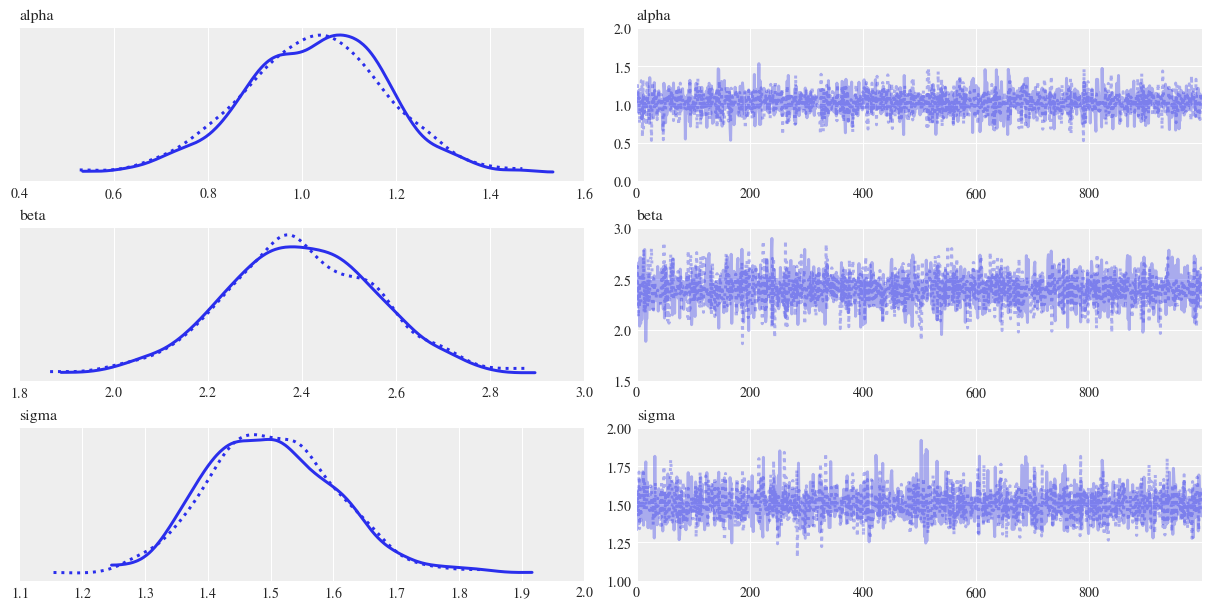

In [127]:
az.plot_trace(trace);

In [128]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.03,0.15,0.74,1.31,0.0,0.0,3254.86,1727.89,1.0
beta,2.40,0.16,2.12,2.71,0.0,0.0,2967.06,1322.18,1.0
sigma,1.50,0.10,1.32,1.69,0.0,0.0,3054.07,1656.33,1.0


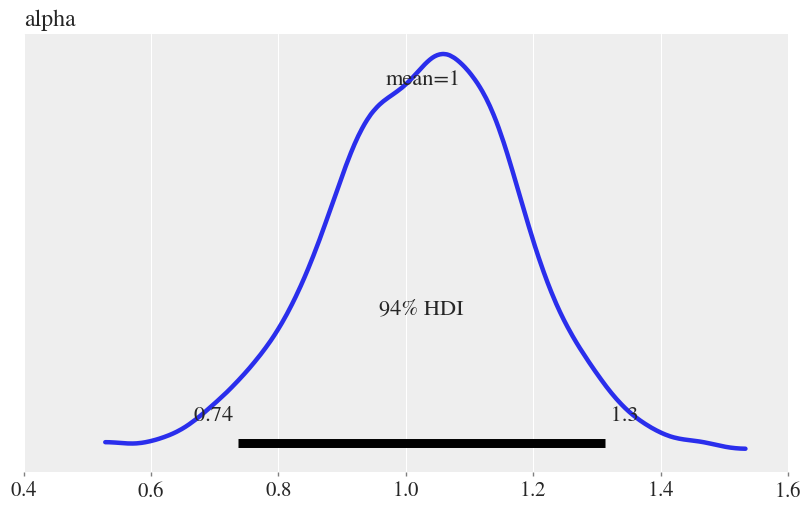

In [129]:
az.plot_posterior(trace, var_names=['alpha'], figsize=(8, 5));

In [130]:
with linear_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=prng)

Output()

In [131]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [132]:
idata = pm.sample_prior_predictive(model=linear_model)

In [133]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [134]:
Sampling: [Y_obs, alpha, beta, sigma]

In [135]:
trace.extend(idata)

In [136]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

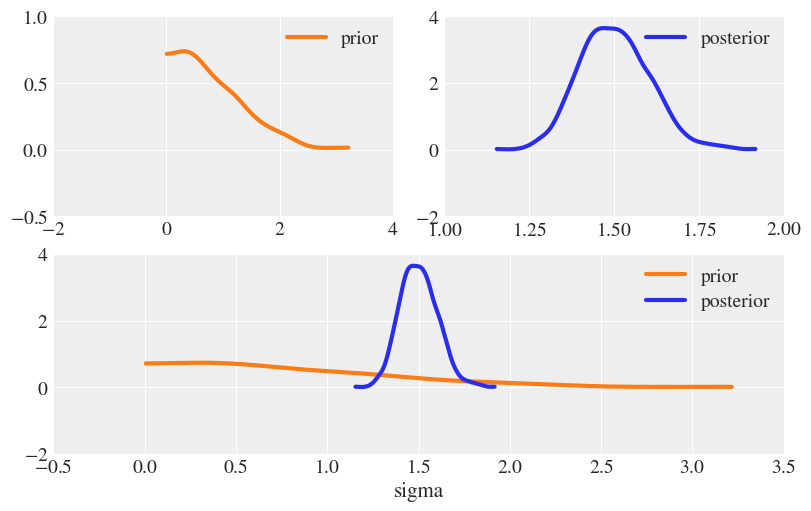

In [137]:
az.plot_dist_comparison(trace, var_names=["sigma"], figsize=(8, 5));

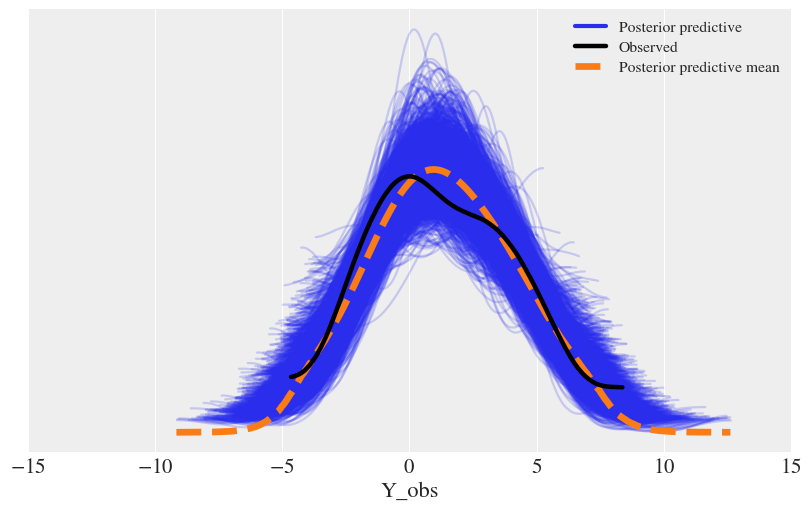

In [138]:
az.plot_ppc(trace, group="posterior", figsize=(8, 5));

In [139]:
post = trace.posterior
mu_pp = post["alpha"] + post["beta"] * xr.DataArray(X, dims=["obs_id"])

In [140]:
mu_pp

<xarray.DataArray (chain: 2, draw: 1000, obs_id: 100)> Size: 2MB
array([[[3.24601389, 1.02799578, 3.50743521, ..., 0.73659732,
         2.05640827, 1.84841682],
        [3.32214533, 0.99372043, 3.59657947, ..., 0.68781696,
         2.07332444, 1.85497975],
        [3.46797052, 1.00763428, 3.75795208, ..., 0.68440058,
         2.14840067, 1.91768619],
        ...,
        [3.35793247, 0.93250127, 3.64380002, ..., 0.61385332,
         2.05708349, 1.82964218],
        [3.15000661, 0.817301  , 3.42494529, ..., 0.51083513,
         1.89888981, 1.68014371],
        [3.21821744, 0.90546561, 3.49080431, ..., 0.60162124,
         1.9778026 , 1.76092763]],

       [[3.08639067, 0.88454556, 3.3459058 , ..., 0.59527187,
         1.90545923, 1.69898438],
        [3.72455554, 1.13619046, 4.0296269 , ..., 0.79613661,
         2.33631906, 2.09359886],
        [3.11064547, 0.94920881, 3.36539795, ..., 0.66524389,
         1.95138658, 1.74870098],
        ...,
        [3.21258515, 1.02219711, 3.47074991, ..., 0.73442862,
         2.03779856, 1.83239808],
        [3.4599065 , 0.88666517, 3.76319534, ..., 0.54859824,
         2.07978145, 1.83847946],
        [3.38013417, 1.02611623, 3.65758478, ..., 0.7168504 ,
         2.11758678, 1.89684214]]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Dimensions without coordinates: obs_id

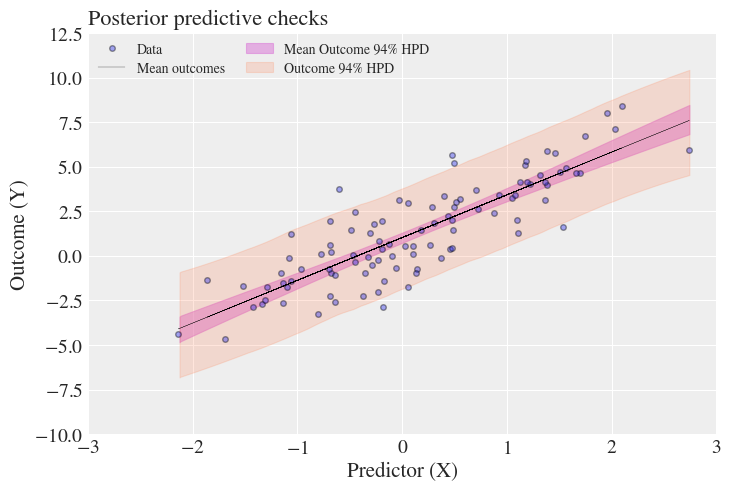

In [141]:
fig, ax = plt.subplots()
ax.plot(X, Y, "o", ms=4, alpha=0.4, label="Data")
ax.plot(X, mu_pp.mean(axis=(0, 1)), label="Mean outcomes", alpha=1, lw=0.2, color="k")
az.plot_hdi(
    X,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.5, "color": "orchid", "label": "Mean Outcome 94% HPD"},
)
az.plot_hdi(
    X,
    trace["posterior_predictive"]["Y_obs"],
    ax=ax,
    fill_kwargs={"alpha": 0.2, "color": "coral", "label": "Outcome 94% HPD"},
)
ax.set_xlabel("Predictor (X)")
ax.set_ylabel("Outcome (Y)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

In [142]:
# True parameter values
α_true, β_true, σ_true, γ_true = 1, 2.5, 1.5, 6

# Size of dataset
size = 200

num_samples = 1000
num_chains = 4

# Predictor variables
X_cat = prng.standard_normal(size)
D = prng.binomial(1, 0.4, size)  # This chooses 1 or 0 with 0.4 prob for 1

# Simulate outcome variable
Y_cat = α_true + β_true * X_cat + γ_true*D + prng.standard_normal(size) * σ_true

In [143]:
with pm.Model() as linear_model_with_dummy:
    # Priors for unknown model parameters
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)
    γ = pm.Normal("γ", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", sigma=1)

    # Expected value of outcome
    μ = α + β * X_cat + γ * D

    # Likelihood (sampling distribution) of observations
    Y_cat_obs = pm.Normal("Y_obs", mu=μ, sigma=σ, observed=Y_cat)

    # Sample the posterior
    trace = pm.sample(num_samples, return_inferencedata=True, chains=num_chains)

Output()

Output()

Output()

Output()

In [144]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.77,0.13,0.53,1.01,0.0,0.0,3149.81,2747.55,1.0
β,2.45,0.10,2.26,2.63,0.0,0.0,3509.68,2944.23,1.0
γ,6.00,0.20,5.63,6.39,0.0,0.0,3243.44,3061.07,1.0
σ,1.40,0.07,1.27,1.53,0.0,0.0,3697.48,2709.26,1.0


In [145]:
random_state = 42  # We'll use this throughout to make this page reproducible
prng = np.random.default_rng(random_state)

In [146]:
from sklearn.datasets import make_regression
X, y, coef = make_regression(n_samples=500, n_features=6, noise=0.5, random_state=random_state, coef=True)

In [147]:
reg_df = pd.DataFrame(X)
reg_df["y"] = y
reg_df.head()

,0,1,2,3,4,5,y
0,-0.753965,0.281191,-0.062593,-0.280675,0.758929,0.104201,43.220530
1,1.031845,-0.439731,0.196555,-1.485560,-0.186872,1.446978,-9.556226
2,-0.600639,0.110923,0.375698,-0.291694,-0.544383,-1.150994,-62.911906
3,0.998311,-0.322320,1.521316,-0.431620,1.615376,1.217159,307.752538
4,0.338496,0.770865,1.143754,-0.415288,0.235615,-1.478586,167.728761


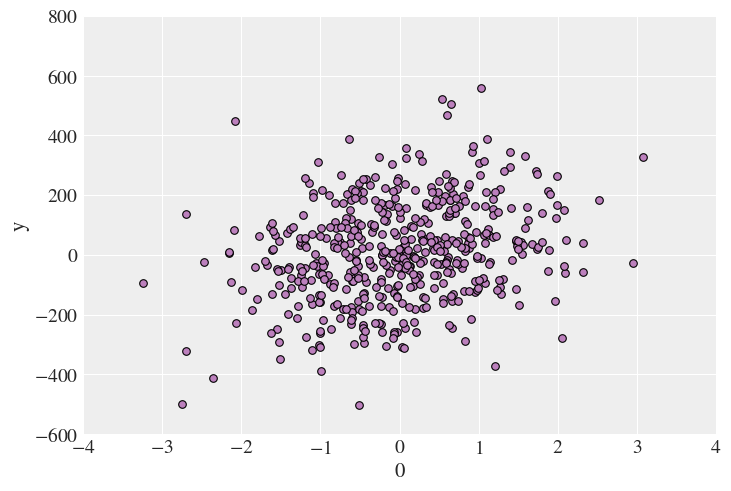

In [148]:
reg_df.plot.scatter(x=0, y="y", s=30);

In [149]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(reg_df, random_state=random_state, test_size=0.2)
train_df.head()

,0,1,2,3,4,5,y
249,-1.116524,1.533728,-1.707358,1.235812,-0.629263,-0.535801,-85.096380
433,-2.123896,-0.808298,-0.599393,-0.525755,2.189803,-0.839722,-89.842998
19,1.117399,-0.548287,0.501783,1.448499,-0.155898,0.160018,85.391162
322,0.484733,1.281016,0.852774,-0.846357,-0.447322,0.067856,165.681418
332,-0.019260,-0.191028,0.784604,-0.262891,-2.562334,2.412615,-99.893249


In [150]:
from sklearn import linear_model

reg_lasso = linear_model.Lasso(alpha=0.1, random_state=random_state)
reg_lasso.fit(train_df.iloc[:, :-1], train_df["y"])  # note that all but final column is passed as X

Lasso(alpha=0.1, random_state=42)

In [151]:
reg_lasso.coef_

array([43.04444381, 98.23909293, 96.83389336, 34.68124549, 81.74516152,
       25.85780195])

In [152]:
# ridge
reg_ridge = linear_model.Ridge(alpha=0.1, random_state=random_state)
reg_ridge.fit(train_df.iloc[:, :-1], train_df["y"])

Ridge(alpha=0.1, random_state=42)

In [153]:
# elastic net w/ 50:50 split between ridge and lasso
reg_elast = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=random_state, fit_intercept=False)
reg_elast.fit(train_df.iloc[:, :-1], train_df["y"])

ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.7, random_state=42)

In [154]:
reg_lasso.predict(test_df.iloc[:5, :-1])

array([ 163.08609994, -169.85887763,  -66.33847724,  -35.00337041,
       -262.31589457])

In [155]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true=test_df["y"], y_pred=reg_lasso.predict(test_df.iloc[:, :-1]))

0.3965445345370078

In [156]:
def get_nice_name_algo(object_in):
    return str(object_in.__class__).strip(">'").split(".")[-1]

In [157]:
from sklearn.metrics import mean_squared_error

models = [reg_lasso, reg_ridge, reg_elast]
model_names = [get_nice_name_algo(model) for model in models]

mse_df = pd.DataFrame(index=["out-of-sample", "in-sample"],
                      columns=model_names)

for model, name in zip(models, model_names):
    mse_df.loc["out-of-sample", name] = (
        mean_squared_error(y_true=test_df["y"],
                           y_pred=model.predict(test_df.iloc[:, :-1]))
    )

mse_df.head()

,Lasso,Ridge,ElasticNet
out-of-sample,0.396545,0.324896,27.005172
in-sample,NaN,NaN,NaN


In [158]:
for model, name in zip(models, model_names):
    mse_df.loc["in-sample", name] = (
        mean_squared_error(y_true=train_df["y"],
                           y_pred=model.predict(train_df.iloc[:, :-1]))
    )

mse_df

,Lasso,Ridge,ElasticNet
out-of-sample,0.396545,0.324896,27.005172
in-sample,0.317716,0.256303,28.493246


In [159]:
results_df = pd.DataFrame()

for model, name in zip(models, model_names):
    results_df[name] = model.predict(test_df.iloc[:, :-1])

results_df["truth"] = test_df["y"].values
# NB: .values important in line above as test_df has a different index
# that will try and align with index on results_df. .values returns only the
# numbers with no indexing.

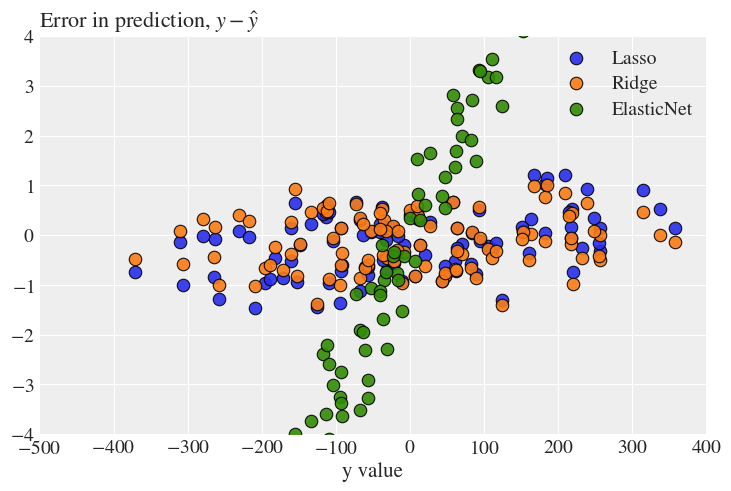

In [160]:
fig, ax = plt.subplots()

for column in results_df.columns[:-1]:
    ax.scatter(results_df["truth"], results_df["truth"] - results_df[column], alpha=0.9, label=column)

ax.legend()
ax.set_ylim(-4, 4)
ax.set_xlabel("y value")
ax.set_title(r"Error in prediction, $y - \hat{y}$")
plt.show()

In [161]:
from sklearn.svm import SVR

reg_svr = SVR(kernel="linear", C=10)
reg_svr.fit(train_df.iloc[:, :-1], train_df["y"])

mean_squared_error(y_true=test_df["y"],
                   y_pred=reg_svr.predict(test_df.iloc[:, :-1])).round(4)

0.3295

In [162]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct

kernel = ConstantKernel(0.1, (0.01, 10.0)) * (
    DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2
)

reg_gauss = GaussianProcessRegressor(random_state=random_state, kernel=kernel)
reg_gauss.fit(train_df.iloc[:, :-1], train_df["y"])

mean_predictions_gpr, std_predictions_gpr = reg_gauss.predict(
    test_df.iloc[:, :-1],
    return_std=True,
)

mean_squared_error(y_true=test_df["y"],
                   y_pred=mean_predictions_gpr).round(4)

0.3405

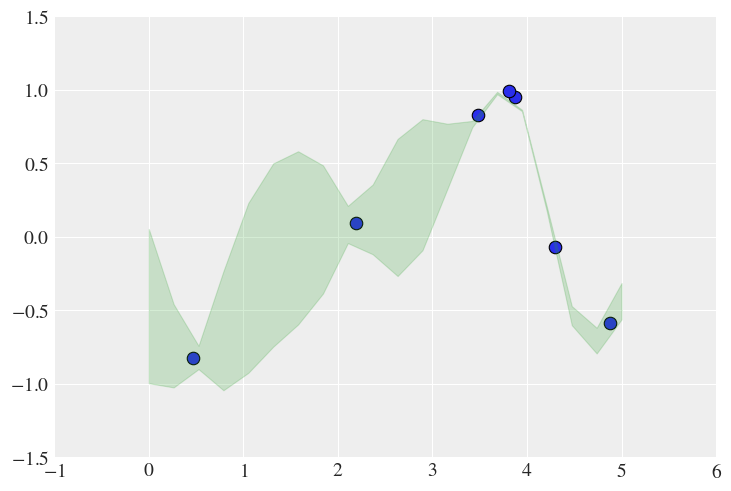

In [163]:
from sklearn.gaussian_process.kernels import RBF

X_gpr_1d = prng.uniform(0, 5, 7).reshape(-1, 1)
y_gpr_1d = np.sin((X_gpr_1d[:, 0] - 2.5) ** 2)

kernel_gpr_1d = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))

gpr_1d = GaussianProcessRegressor(random_state=random_state, kernel=kernel_gpr_1d)
gpr_1d.fit(X_gpr_1d, y_gpr_1d)

x_gpr_grid = np.linspace(0, 5, 20)
X_gpr_grid = x_gpr_grid.reshape(-1, 1)


y_mean_gpr, y_std_gpr = gpr_1d.predict(X_gpr_grid, return_std=True)

fig, ax = plt.subplots()
ax.scatter(X_gpr_1d, y_gpr_1d)
ax.fill_between(
    x_gpr_grid,
    y_mean_gpr - y_std_gpr,
    y_mean_gpr + y_std_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.show()

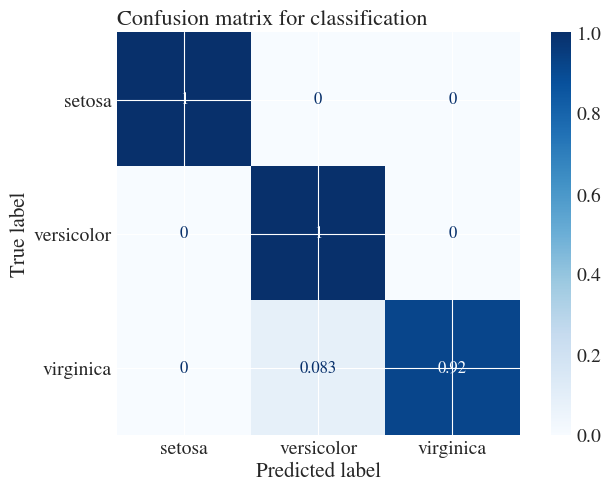

In [164]:
from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_iris, y_iris, random_state=random_state)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel="linear", C=0.0135).fit(X_train_i, y_train_i)
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test_i,
        y_test_i,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title("Confusion matrix for classification")
plt.show()

In [165]:
print(classification_report(y_test_i, classifier.predict(X_test_i), target_names=class_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.92      1.00      0.96        11
   virginica       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



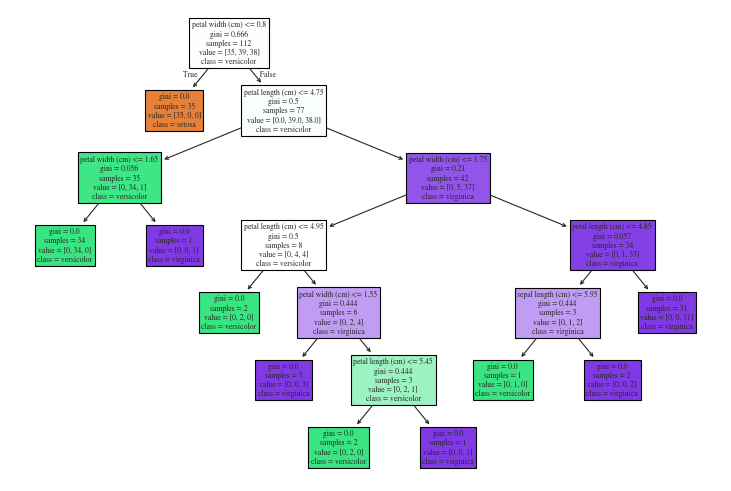

In [166]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_i, y_train_i)
tree.plot_tree(clf, class_names=list(class_names), filled=True, feature_names=iris.feature_names);